In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSE
from tensorflow.keras.optimizers import Adam


In [2]:
tf.compat.v1.logging.set_verbosity(30)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("data/loureiro_40casas_location.csv")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df['Energy'] = df['Energy'].astype(np.float32)
df

,Energy,Location
Time,,
2022-05-05 12:00:00,0.068,Energy_1
2022-05-05 12:15:00,0.070,Energy_1
2022-05-05 12:30:00,0.122,Energy_1
2022-05-05 12:45:00,0.132,Energy_1
2022-05-05 13:00:00,0.125,Energy_1
...,...,...
2023-06-07 01:15:00,0.003,Energy_164
2023-06-07 01:30:00,0.004,Energy_164
2023-06-07 01:45:00,0.003,Energy_164


<Axes: xlabel='Time'>

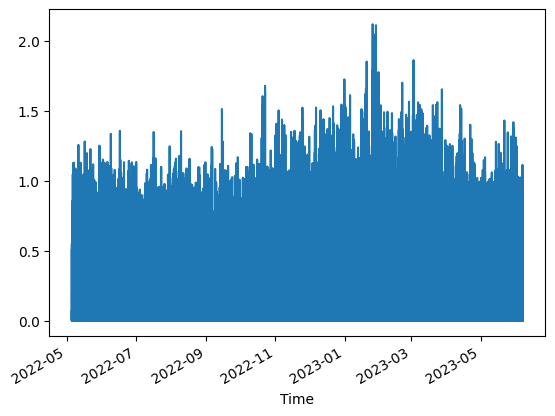

In [4]:
energy = df['Energy']
energy.plot()

In [5]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
data_list = []
scaler_list = []

# Iterate over each house
for house_id in df['Location'].unique():
    house_data = df[df['Location'] == house_id]['Energy'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(house_data)
    data_list.append(scaled_data)
    scaler_list.append(scaler)

# Split the dataset for each house into training and testing sets
train_data_list = []
test_data_list = []
train_size = int(len(data_list[0]) * 0.8)  # 80% for training, 20% for testing

for data in data_list:
    train_data_list.append(data[:train_size])
    test_data_list.append(data[train_size:])

In [7]:
sequence_length = 16

train_X_list, train_y_list = [], []
test_X_list, test_y_list = [], []

for train_data, test_data in zip(train_data_list, test_data_list):
    train_X, train_y = [], []
    test_X, test_y = [], []

    for i in range(len(train_data) - sequence_length):
        train_X.append(train_data[i:i+sequence_length])
        train_y.append(train_data[i+sequence_length])

    for i in range(len(test_data) - sequence_length):
        test_X.append(test_data[i:i+sequence_length])
        test_y.append(test_data[i+sequence_length])

    train_X_list.append(train_X)
    train_y_list.append(train_y)
    test_X_list.append(test_X)
    test_y_list.append(test_y)

train_X = np.concatenate(train_X_list)
train_y = np.concatenate(train_y_list)
test_X = np.concatenate(test_X_list)
test_y = np.concatenate(test_y_list)

In [8]:
pd.DataFrame(train_X.reshape(-1,16))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.044944,0.046266,0.080634,0.087244,0.082617,0.058824,0.074025,0.073364,0.060145,0.103106,0.249174,0.058824,0.063450,0.061467,0.194316,0.321216
1,0.046266,0.080634,0.087244,0.082617,0.058824,0.074025,0.073364,0.060145,0.103106,0.249174,0.058824,0.063450,0.061467,0.194316,0.321216,0.070059
2,0.080634,0.087244,0.082617,0.058824,0.074025,0.073364,0.060145,0.103106,0.249174,0.058824,0.063450,0.061467,0.194316,0.321216,0.070059,0.054858
3,0.087244,0.082617,0.058824,0.074025,0.073364,0.060145,0.103106,0.249174,0.058824,0.063450,0.061467,0.194316,0.321216,0.070059,0.054858,0.064111
4,0.082617,0.058824,0.074025,0.073364,0.060145,0.103106,0.249174,0.058824,0.063450,0.061467,0.194316,0.321216,0.070059,0.054858,0.064111,0.052214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215955,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000
1215956,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000
1215957,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000
1215958,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000,0.060000,0.080000,0.080000,0.060000,0.080000,0.080000,0.080000,0.060000


In [9]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_X, train_y, epochs=10, batch_size=40)

Epoch 1/10
30399/30399 [==============================] - 36s 1ms/step - loss: 0.0039
Epoch 2/10
30399/30399 [==============================] - 34s 1ms/step - loss: 0.0037
Epoch 3/10
30399/30399 [==============================] - 35s 1ms/step - loss: 0.0037
Epoch 4/10
30399/30399 [==============================] - 36s 1ms/step - loss: 0.0037
Epoch 5/10
30399/30399 [==============================] - 35s 1ms/step - loss: 0.0036
Epoch 6/10
30399/30399 [==============================] - 36s 1ms/step - loss: 0.0036
Epoch 7/10
30399/30399 [==============================] - 35s 1ms/step - loss: 0.0036
Epoch 8/10
30399/30399 [==============================] - 35s 1ms/step - loss: 0.0036
Epoch 9/10
30399/30399 [==============================] - 35s 1ms/step - loss: 0.0035
Epoch 10/10
30399/30399 [==============================] - 34s 1ms/step - loss: 0.0035


In [10]:
predictions = model.predict(test_X)
mse = np.mean(np.square(predictions - test_y))
print("Mean Squared Error (MSE):", mse)

9485/9485 [==============================] - 5s 501us/step
Mean Squared Error (MSE): 0.003246666


In [14]:
performance_metrics(predictions, test_y)

MSE: 0.0032
WAPE: 38.25
R2: 0.6436


(0.0032, 38.25, 0.6436)

In [15]:
WINDOW_SIZE = 8
X1, y1 = df_to_X_y(energy, WINDOW_SIZE)
X1.shape, y1.shape

((1520752, 8, 1), (1520752,))

In [18]:
train_samples = int(len(X1) * 0.7)
test_samples = int(len(X1) * 0.2)
X_train1, y_train1 = X1[:train_samples], y1[:train_samples]
X_val1, y_val1 = X1[train_samples:-test_samples], y1[train_samples:-test_samples]
X_test1, y_test1 = X1[-test_samples:], y1[-test_samples:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1064526, 8, 1),
 (1064526,),
 (152076, 8, 1),
 (152076,),
 (304150, 8, 1),
 (304150,))

In [19]:
model = Sequential()
model.add(InputLayer((8, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('models/model5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MSE()])

In [23]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1], batch_size=6)

Epoch 1/10
177388/177421 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

177421/177421 [==============================] - 230s 1ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 2/10
177421/177421 [==============================] - 230s 1ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 3/10
177421/177421 [==============================] - 222s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/10
177421/177421 [==============================] - 228s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/10
177421/177421 [==============================] - 232s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 6/10
177421/177421 [==============================] - 230s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0048 - val_mean_squared_error

In [24]:
from tensorflow.keras.models import load_model
model1 = load_model('models/model5')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [25]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train1})
train_results

33267/33267 [==============================] - 20s 584us/step


,Train Predictions,Actuals
0,0.108478,0.091
1,0.095032,0.156
2,0.148896,0.377
3,0.296302,0.089
4,0.082362,0.096
...,...,...
1064521,0.043294,0.024
1064522,0.030463,0.039
1064523,0.043310,0.039
1064524,0.040735,0.410


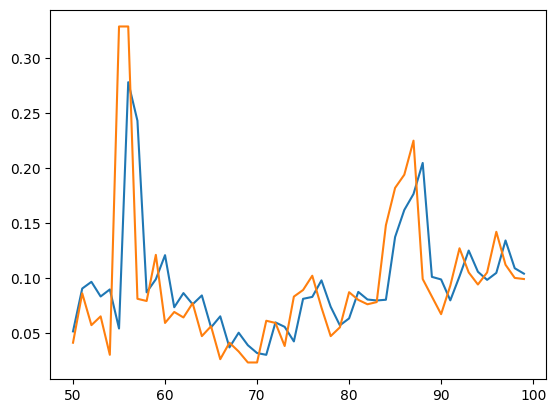

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [27]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val1})
val_results

4753/4753 [==============================] - 3s 595us/step


,Val Predictions,Actuals
0,0.218427,0.202
1,0.193453,0.359
2,0.294769,0.354
3,0.291375,0.515
4,0.407206,0.553
...,...,...
152071,0.053807,0.045
152072,0.056058,0.053
152073,0.059940,0.053
152074,0.057889,0.084


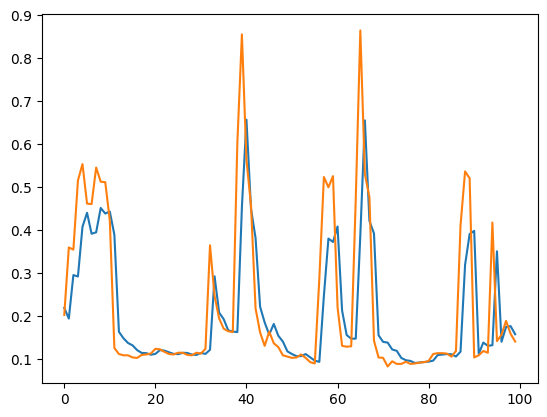

In [28]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [29]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

9505/9505 [==============================] - 5s 576us/step


,Test Predictions,Actuals
0,0.015350,0.004
1,0.022203,0.004
2,0.013397,0.004
3,0.012684,0.004
4,0.010283,0.004
...,...,...
304145,0.006113,0.003
304146,0.005428,0.004
304147,0.006326,0.003
304148,0.005362,0.004


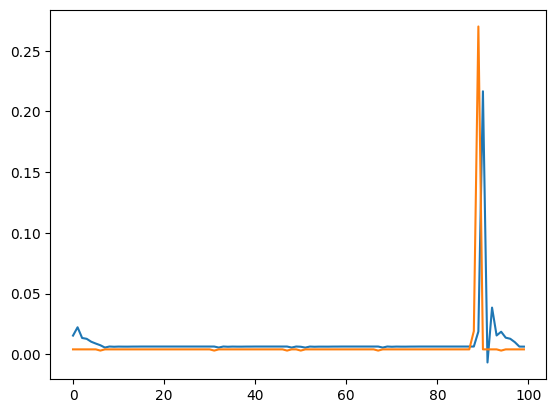

In [30]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [ ]:
# mostrar erro (diferencça entre real e simulado)

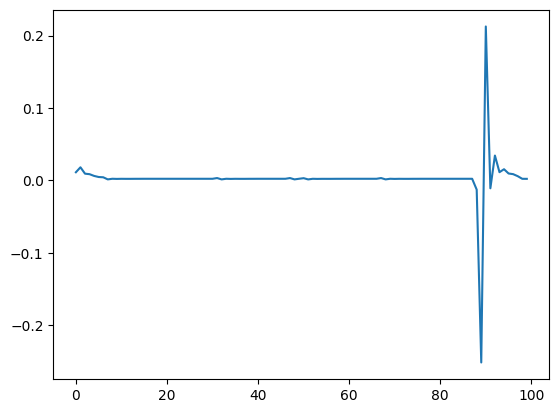

In [31]:
diff = test_results['Test Predictions'] - test_results['Actuals']
#plt.plot(range(test_results.shape[0]), diff)
plt.plot(range(100), diff[:100])

In [32]:
def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 

In [33]:
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

In [34]:
performance_metrics(train_results['Train Predictions'], train_results['Actuals'])

MSE: 0.0054
WAPE: 39.09
R2: 0.6438


(0.0054, 39.09, 0.6438)

In [35]:
performance_metrics(val_results['Val Predictions'], val_results['Actuals'])

MSE: 0.0047
WAPE: 28.47
R2: 0.7006


(0.0047, 28.470000000000002, 0.7006)

In [36]:
performance_metrics(test_results['Test Predictions'], test_results['Actuals'])

MSE: 0.0038
WAPE: 43.70
R2: 0.5357


(0.0038, 43.7, 0.5357)